In [1]:
# imports from the pyfoomb package
import pyfoomb
print(f'Current package version of {pyfoomb.__name__}: {pyfoomb.__version__}')

from pyfoomb import BioprocessModel
from pyfoomb import ObservationFunction
from pyfoomb import Caretaker
from pyfoomb import Visualization
from pyfoomb import Measurement

C:\Users\hemmerich\AppData\Local\Continuum\miniconda3\envs\pyfoomb-dev\lib\site-packages\assimulo\solvers\odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


Current package version of pyfoomb: 2.17.7


In [2]:
from matplotlib import pyplot
import numpy
import pandas

# Set seed of random number generator for reproducibility
numpy.random.seed(123)

# Parameter Estimation

The parameter estimation workflow is demonstrated using the simpe toy model `SequentialKinetics`, which was introduced in the first example notebook.

In [3]:
# Defines the model class
class SequentialKinetic(BioprocessModel):
    
    def rhs(self, t, y):
        # Unpacks the state vector. The states are alphabetically ordered.
        A, B, C = y
        
        # Unpacks the model parameters.
        k1 = self.model_parameters['k1']
        k2 = self.model_parameters['k2']
        
        # Defines the derivatives.
        dAdt = -k1 * A
        dBdt = k1 * A - k2*B
        dCdt = k2*B
        
        # Returns the derivative as list (or numpy array).
        # The order corresponds to the state vector.
        return [dAdt, dBdt, dCdt]
    
# Defines a dictionary for the initial values.
# The keys corresponds to the model states, extended by a 0 (zero).
initial_values = {
    'A0' : 50.0,
    'B0' : 2.5,
    'C0' : 0.0,
}

# Defines a dictionary for the model parameters
# The keys match those variable names used in the model class
model_parameters = {
    'k1' : 0.2,
    'k2' : 0.1,
}

# Generating artificial, noisy data

We will use the model to run a forward simulation, from which data points are chosen randomly. These datapoints will be perturbed with noise, and from these, the parameter values that generated this data are estimated (i.e., the inverse problem).

In [4]:
# Defines a helper method that creates a noisy dataset, based on a forward simulation
def noisy_samples(simulations, samples=5, rel_err=0.05, abs_err=0.05, repetitions=3, with_errors=True):
        artifical_data = []
        for simulation in simulations:
            _name = simulation.name
            _replicate_id = simulation.replicate_id
            _timepoints = simulation.timepoints
            _values = simulation.values
            _rnd_values = [
                numpy.random.normal(loc=_values, scale=abs(_values*rel_err+abs_err)) 
                for _ in range(repetitions)
            ]
            _values = numpy.mean(_rnd_values, axis=0)
            _errors = numpy.std(_rnd_values, ddof=1, axis=0)
            selector = numpy.sort(
                numpy.random.choice(range(len(_timepoints)), size=samples, replace=False),
            )
            if with_errors:
                artifical_data.append(
                    Measurement(name=_name, timepoints=_timepoints[selector], values=_values[selector], errors=_errors[selector], replicate_id=_replicate_id),
                )
            else:
                artifical_data.append(
                    Measurement(name=_name, timepoints=_timepoints[selector], values=_values[selector], replicate_id=_replicate_id),
                )
        return artifical_data

Beside the `BioprocessModel` class, the `Caretaker` class is one of the most important ones in `pyFOOMB`. 

In [5]:
# Instantiate a Caretaker, which manages the model and its parametrization.
caretaker = Caretaker(
    bioprocess_model_class=SequentialKinetic, 
    model_parameters=model_parameters, 
    initial_values=initial_values,
)

# Runs a forward simulation.
simulation = caretaker.simulate(t=24)

After running a forward simulation, the resulting dictionary of `TimeSeries` subclass objects is used to create another dictionary with different `TimeSeries` subclass objects, namely a dictionary of `Measurement` objects. 

In [6]:
# Create the noisy data
data = noisy_samples(simulation, rel_err=0.1)

Each datapoint deviates from its simulated counterparts in a randomized fashion, and has an error. Note that the five datapoints for each `Measurement` object show different time points. 

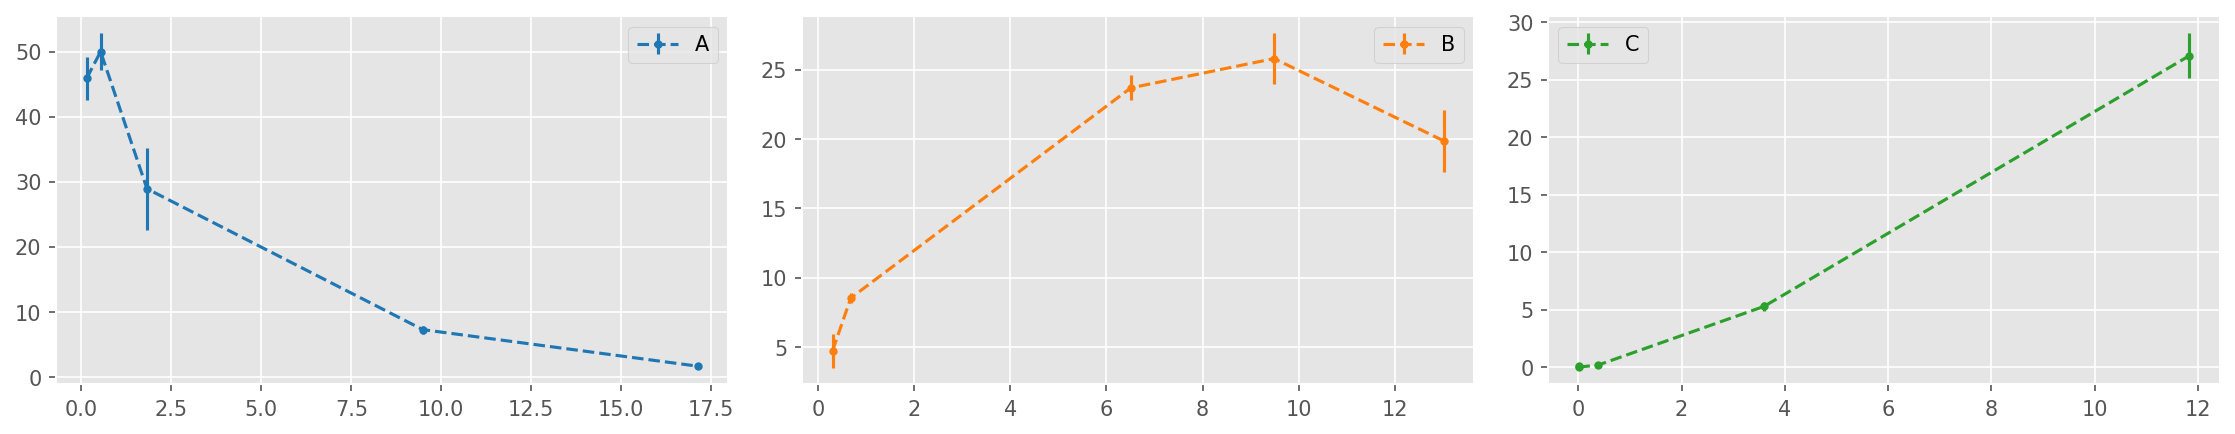

In [7]:
# Visualize the noisy data
_ = Visualization.show_kinetic_data(data)

# Parameter estimation a.k.a. model calibation

Consider now we are confident that the chose model is sufficient to explain the data we obtained and that are interested in the values of `k1`, `k2`, and `B0`. Value for `A0` and `C0` are assumed to be known.

First, we create a list `unknowns` containing the names of the parameters whose values we would like to estimate. A corresponding list `bounds` is created, with a tuple comprising lower and upper bounds for the parameter values. These bound should be chosen according to expert knowledge.

In [8]:
unknowns = ['k1', 'k2', 'B0']
bounds = [(0, 100), (0, 100), (0, 50)]

Per default, the caretaker's `estimate` method makes use of a global, derivative-free optimizer. Several keyword arguments can be used to, e.g. report on the estimation progress. It is also possible to use a local optimizer, for which an initial guess is needed. In this case, you provide the `unknowns` as dictionary. As always, both methods come with pros and cons, which need to be evaluated for each use case.  

In [9]:
est, est_info = caretaker.estimate(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data, 
    report_level=2,
)


----------Results from differential evolution optimizer

Estimated parameters:
B0: 2.482554160625555
k1: 0.19699352170703432
k2: 0.10876737267438642

Runtime was 0.07 min

----------
     fun: 12.711632843828253
     jac: array([-3.85469436e-05,  2.48867593e-04,  4.47464288e-04])
 message: 'Optimization terminated successfully.'
    nfev: 1925
     nit: 40
 success: True
       x: array([2.48255416, 0.19699352, 0.10876737])


There is also a convenient method available to visually compare the fitted parameters with the measurement data. Since we know also the ground truth (i.e., the forward simulation from the 'true' parameter values), we can compare with these as well.

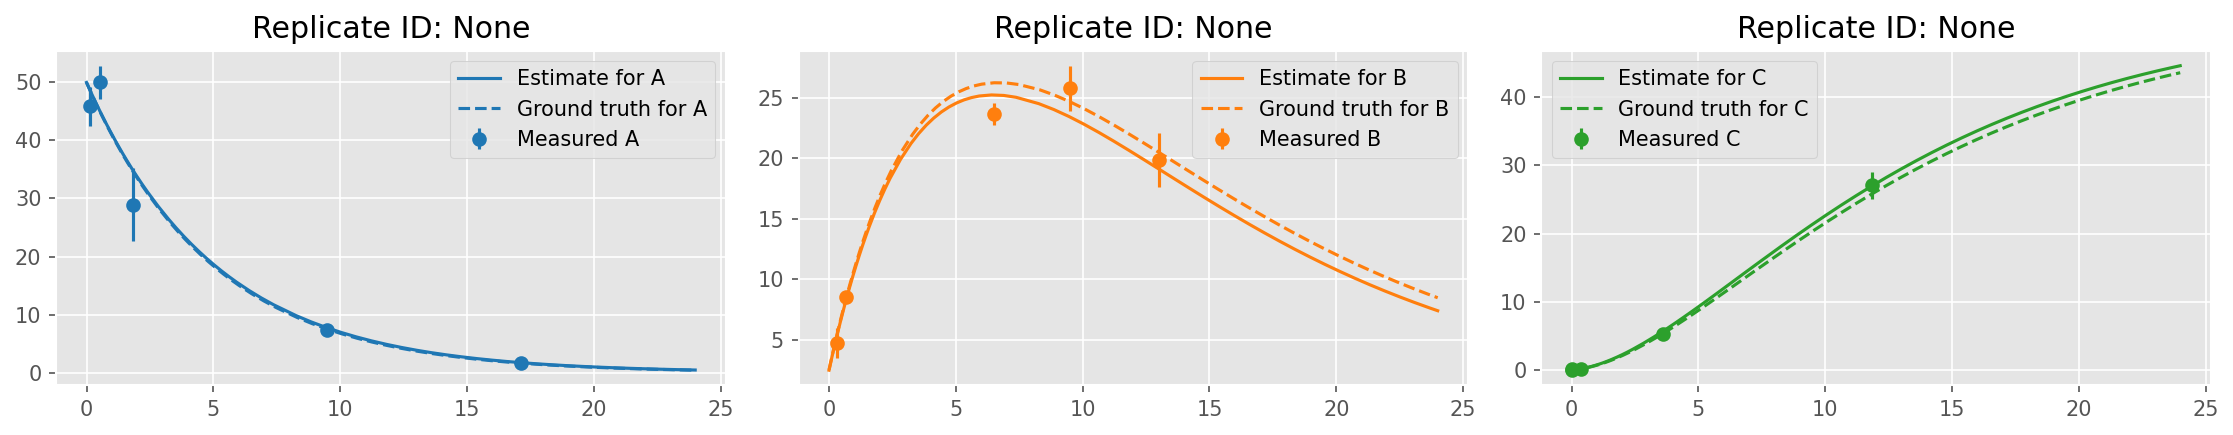

In [10]:
_ = Visualization.compare_estimates(parameters=est, measurements=data, caretaker=caretaker, truth=simulation)

# Uncertainties for parameter estimates

After parameter estimation, uncertainties for these are desirable. Currently, the `pyFOOMB` package provides two methods: 1) Based on Fisher information matrix (FIM), derived from local sensitivities, and 2) Based on Monte-Carlo (MC) sampling.

Strictly speaking, the last method provides both the parameter estimates and corresponding uncertainties at the same time.

First, we'll see how to approximate parameter uncertainities, based on FIM.

In [11]:
parameters_infos = caretaker.get_parameter_uncertainties(estimates=est, measurements=data, report_level=1)


Estimated parameters:
----------
B0: 2.48e+00 +/- 3.32e-01 (13.37 %)
k1: 1.97e-01 +/- 5.35e-03 (2.72 %)
k2: 1.09e-01 +/- 4.87e-03 (4.47 %)


Next, let's have a look at MC sampling. For this method, the data is re-sampled from the specified distribution, and for each sample, a parameter estimation is run and thus, a substantial amount of computation load is required. Luckily, the estimations can be run in parallel, exploiting current (consumer) processor architecture. The resulting empirical parameter distributions are inspected for different metrics, like the median (50 % percentile) as parameter point estimate, and the 16 % and 84 % percentiles as lower and upper uncertainty bounds.

__NOTE__: The MC sampling method requires considerably more computational load than the FIM-based method for calculation of parameter uncertainties.

In [12]:
est_mc, _ = caretaker.estimate_MC_sampling(
    unknowns=unknowns, 
    bounds=bounds, 
    measurements=data, 
    mc_samples=100, 
    report_level=1,
)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   32.4s



Summaries for empirical parameter distributions
-----------------------------------------------
    count      mean       std       min       25%       50%       75%  \
k1  100.0  0.197735  0.005181  0.187494  0.193501  0.198362  0.200695   
k2  100.0  0.108978  0.004993  0.096369  0.105860  0.108874  0.113000   
B0  100.0  2.490225  0.337257  1.725239  2.283508  2.494194  2.709114   

         max  
k1  0.211710  
k2  0.121209  
B0  3.173094  


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:  1.4min finished


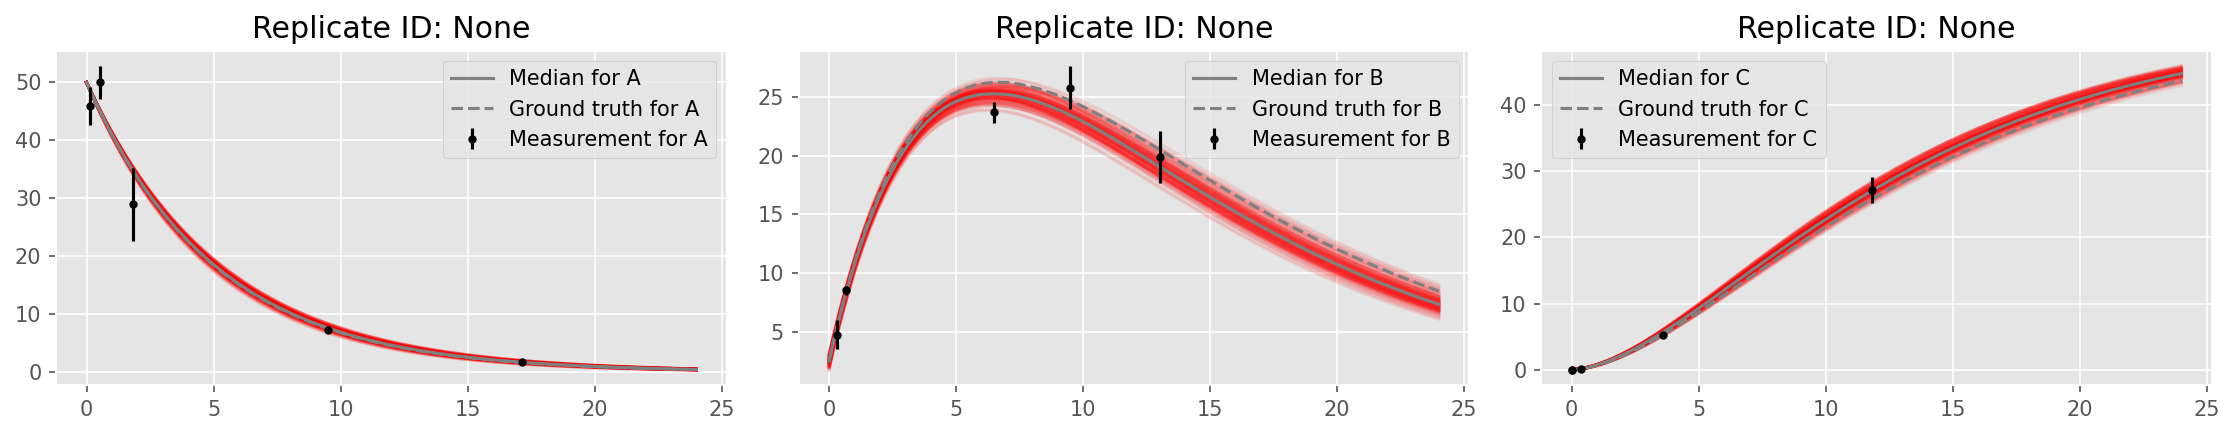

In [13]:
# Show forwards simulations for all parameter estimates with corresponding medians and compare to data
_ = Visualization.compare_estimates_many(
    parameter_collections=est_mc, 
    measurements=data,
    caretaker=caretaker, 
    truth=simulation,
)

Also, the obtained parameter distributions after MC sampling can be evaluated using a corner plot:
* Single parameter distributions
* Pair-wise correlations plots 
* Linear correlation coefficients
* Other point estimates for the parameters

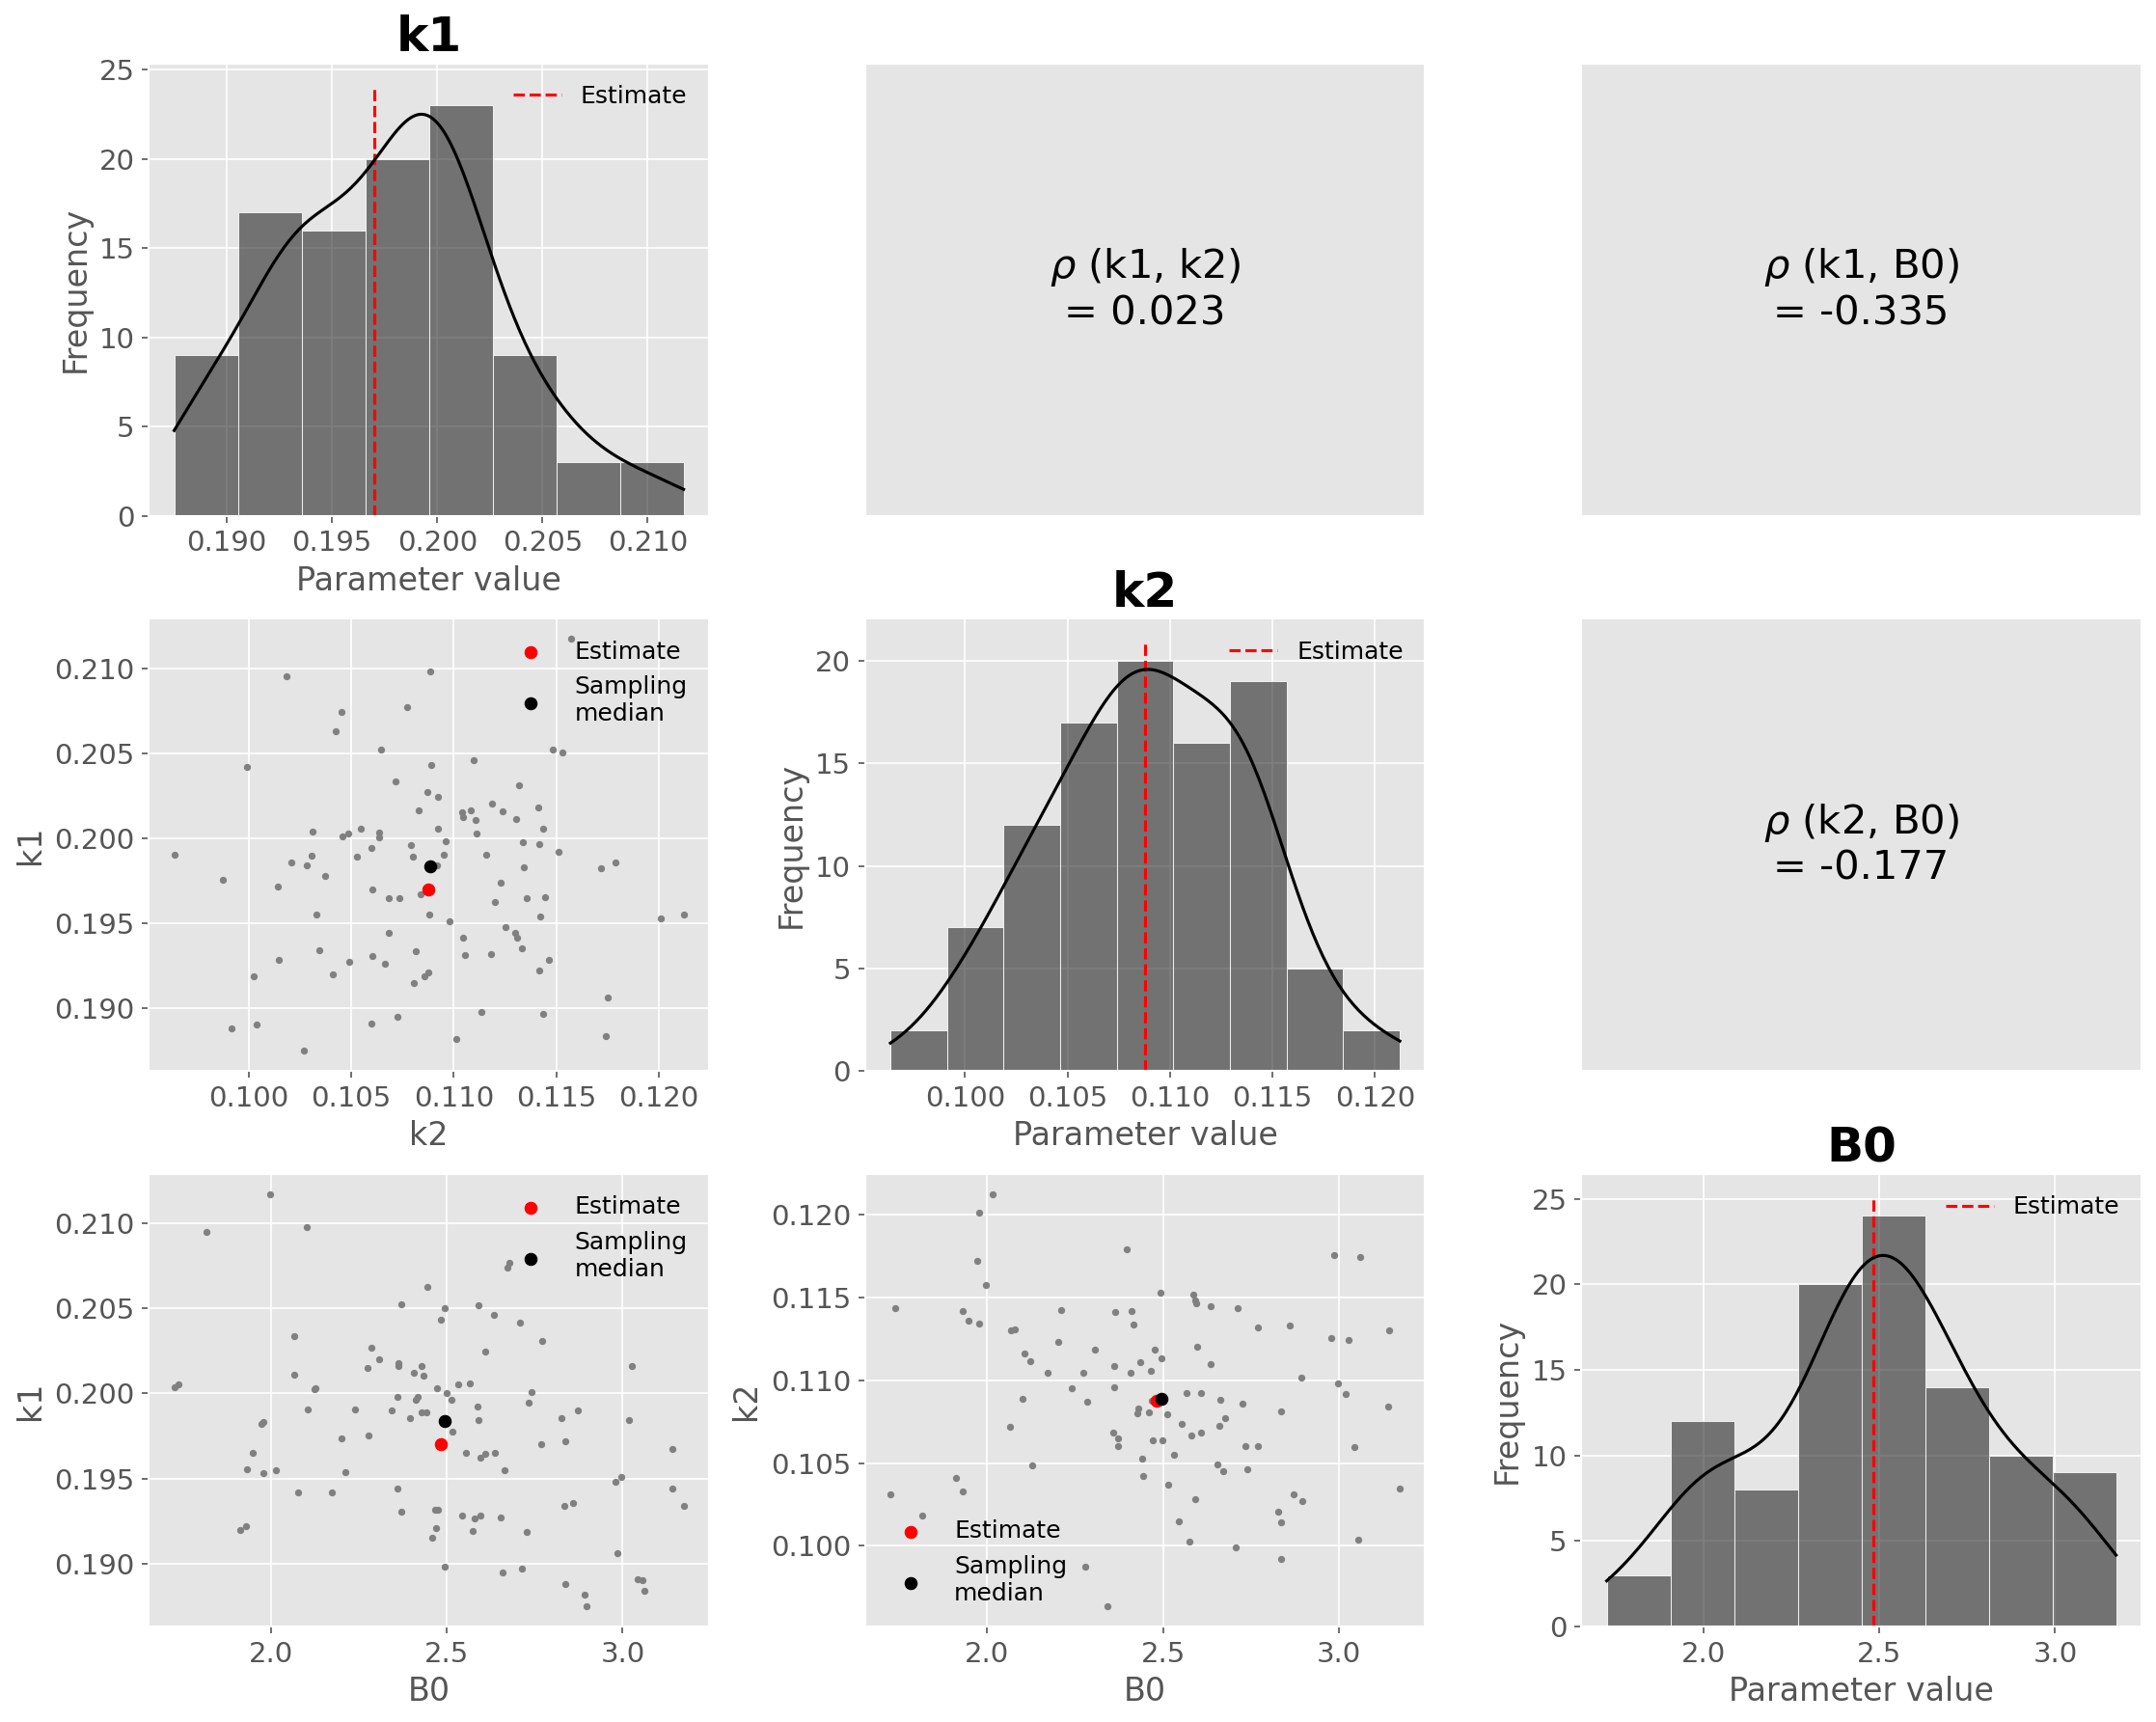

In [14]:
_ = Visualization.show_parameter_distributions(est_mc, show_corr_coeffs=True, estimates=est)

# Comparing the results from the two parameter estimation methods

In [15]:
# Create a dataframe for comparison of estimation results
df_fim = pandas.DataFrame(columns=parameters_infos['Parameters'], index=[0.16, 0.5, 0.84])
df_fim.loc[0.50] = parameters_infos['Values']
df_fim.loc[0.16] = parameters_infos['Values'] - parameters_infos['StdErrs']
df_fim.loc[0.84] = parameters_infos['Values'] + parameters_infos['StdErrs']
df_fim.index.name='Quantile'

df_mc = pandas.DataFrame(est_mc).quantile(q=[0.16, 0.5, 0.84])
df_mc.index.name='Quantile'

_df = pandas.concat(
    [df_fim.T, df_mc.T], 
    keys=['MLE + FIM', 'MC Sampling'], 
    sort=True
).T
_df.reindex(sorted(_df.columns), axis=1)

MC Sampling                     MLE + FIM                    
                  B0        k1        k2        B0        k1        k2
Quantile                                                              
0.16        2.104785  0.192565  0.103677  2.150655  0.191639  0.103901
0.50        2.494194  0.198362  0.108874  2.482554  0.196994  0.108767
0.84        2.836611  0.202087  0.114165  2.814453  0.202348  0.113634

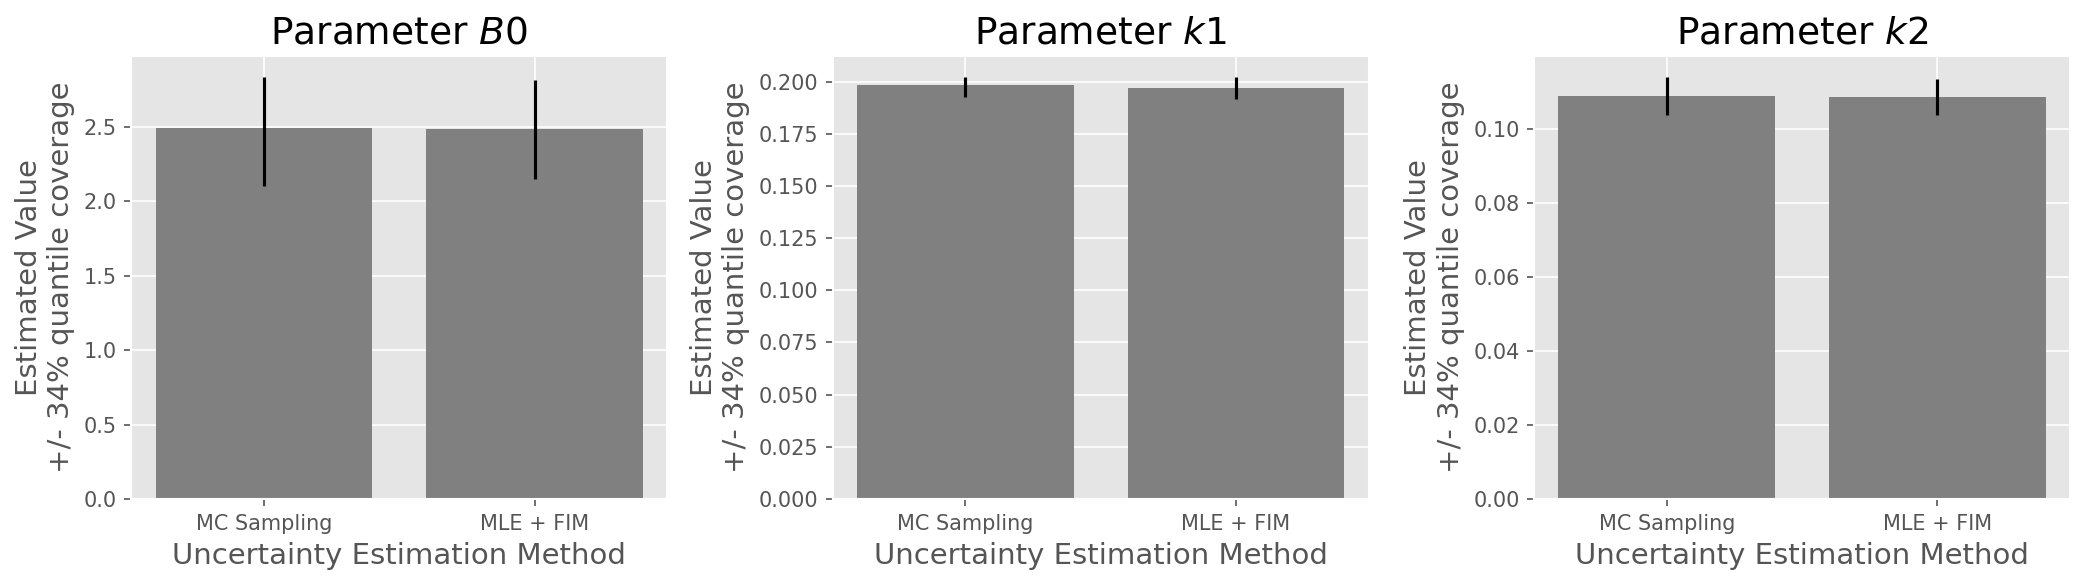

In [16]:
# Create a figure that allows to compare the estimation results visually
ncols = 3
titles = ['Parameter $B0$', 'Parameter $k1$', 'Parameter $k2$']
fig, ax = pyplot.subplots(nrows=1, ncols=ncols, figsize=(14, 4), dpi=150)

for i, _ax in enumerate(ax.flat):
    tmp = _df.stack().to_numpy(dtype=float)[i::3, :]
    _ax.bar(
        x=['MC Sampling', 'MLE + FIM'],
        height=tmp[1,:],
        yerr=[tmp[1,:]-tmp[0,:], tmp[2,:]-tmp[1,:]],
        color='grey',
    )
    _ax.set_title(titles[i], size=18)
    _ax.set_ylabel('Estimated Value\n+/- 34% quantile coverage', size=14)
    _ax.set_xlabel('Uncertainty Estimation Method', size=14)

fig.tight_layout()